In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import ast
from sklearn.neighbors import KNeighborsRegressor
import re
from collections import Counter
from wordcloud import WordCloud

In [2]:
# Load the dataset
df = pd.read_csv('../data/full_data/full_data_base.csv')
df

C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\3646054202.py:2: DtypeWarning: Columns (2,9,11,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/full_data/full_data_base.csv')


,bookId,title,series,author,rating,description,language,isbn,genres,characters,bookFormat,pages,publisher,publishDate,firstPublishDate,awards,numRatings,likedPercent,setting,coverImg
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9780439023481,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",Hardcover,374,Scholastic Press,09/14/08,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780.0,96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",https://i.gr-assets.com/images/S/compressed.ph...
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",Paperback,870,Scholastic Inc.,09/28/04,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623.0,98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,9780062369635,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",Paperback,324,Harper Perennial Modern Classics,05/23/06,07/11/60,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075.0,95.0,"['Maycomb, Alabama (United States)']",https://i.gr-assets.com/images/S/compressed.ph...
3,1885.Pride_and_Prejudice,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,English,NaN,"['Classics', 'Fiction', 'Romance', 'Historical...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",Paperback,279,Modern Library,10/10/00,01/28/13,[],2998241.0,94.0,"['United Kingdom', 'Derbyshire, England (Unite...",https://i.gr-assets.com/images/S/compressed.ph...
4,41865.Twilight,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9780316015844,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",Paperback,501,"Little, Brown and Company",09/06/06,10/05/05,"['Georgia Peach Book Award (2007)', 'Buxtehude...",4964519.0,78.0,"['Forks, Washington (United States)', 'Phoenix...",https://i.gr-assets.com/images/S/compressed.ph...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74784,SzxlzgEACAAJ,Afterimage Slow Motion,NaN,Jyanome,NaN,NaN,en,3964335037,nan - yaoi,NaN,nan - nan,224.0,NaN,2021-12-02,2021-12-02,NaN,NaN,NaN,NaN,NaN
74785,Te04EQAAQBAJ,When Fate Holds Its Breath,NaN,Takiba,NaN,NaN,de,9783551624680,Comics & Graphic Novels - yaoi,NaN,nan - nan,29.0,NaN,2025,2025,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=6MsAE...
74786,s_8_EAAAQBAJ,Midnight Delivery Sex,NaN,Neneko Narazaki,NaN,Mit SNS-Card zum Sammeln in der ersten Auflage...,de,9783551620668,Comics & Graphic Novels - yaoi,NaN,nan - nan,29.0,Hayabusa,2021-05-04,2021-05-04,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=s_8_E...
74787,_yjnEAAAQBAJ,Monster Girl: 2,NaN,Kazuki Funatsu,NaN,"Dopo il loro incontro, Yatsuki si ritrova ad a...",it,9788834915899,Comics & Graphic Novels - isekai comedy,NaN,nan - nan,216.0,Edizioni BD,2020-05-01,2020-05-01,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=_yjnE...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74789 entries, 0 to 74788
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            74789 non-null  object 
 1   title             74789 non-null  object 
 2   series            23470 non-null  object 
 3   author            74517 non-null  object 
 4   rating            53830 non-null  float64
 5   description       71379 non-null  object 
 6   language          73542 non-null  object 
 7   isbn              74028 non-null  object 
 8   genres            74789 non-null  object 
 9   characters        52478 non-null  object 
 10  bookFormat        73316 non-null  object 
 11  pages             73162 non-null  object 
 12  publisher         66657 non-null  object 
 13  publishDate       74420 non-null  object 
 14  firstPublishDate  53463 non-null  object 
 15  awards            52478 non-null  object 
 16  numRatings        53830 non-null  float6

- Standardize all null representations across the DataFrame
- Replace different forms of missing values with NaN to ensure consistent identification

In [4]:
df.replace(
    ['NaN', 'nan', 'None', 'NULL', 'null', 'nan - nan', '', '[]', ' '], 
    np.nan, 
    inplace=True
)
print("All variants of missing values have been converted to NaN for consistent handling.")

All variants of missing values have been converted to NaN for consistent handling.


## Title & Author

Check if there are any duplicates

In [5]:
duplicates_title_author = df[
    df.duplicated(subset=['title', 'author'], keep=False)
]
n_duplicates = duplicates_title_author.groupby(['title', 'author']).size()
print(n_duplicates.sort_values(ascending=False).head(20))

title                                                                author                               
Sara Crewe; Or, What Happened at Miss Minchin's Boarding School      Burnett                                  9
Divine Life Ring System                                              Wu Mei Ren, Da Wan                       6
WIEDERGEBURT: Legend of the Reincarnated Warrior                     Brandon Varnell                          6
Isekai                                                               George Alfaro                            5
Limits of Destiny                                                    Sharlyn G. Branson (Goodreads Author)    5
The Godslaying Tower                                                 Nangong Yuan Jing                        5
The Ultimate Celestial Martial Emperor                               de Yun Piao Dang                         5
Holiday Romance                                                      Charles Dickens                         

In [6]:
df.loc[df['author'] == 'Burnett']

,bookId,title,series,author,rating,description,language,isbn,genres,characters,bookFormat,pages,publisher,publishDate,firstPublishDate,awards,numRatings,likedPercent,setting,coverImg
56619,Q_QLzgEACAAJ,"Sara Crewe; Or, What Happened at Miss Minchin'...",NaN,Burnett,NaN,"Sara Crewe; Or, What Happened at Miss Minchin'...",en,9798567085448,nan - boarding school fiction,NaN,NaN,46.0,NaN,2020-11-18,2020-11-18,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=Q_QLz...
58713,FgV4zgEACAAJ,"Sara Crewe; Or, What Happened at Miss Minchin'...",NaN,Burnett,NaN,"Sara Crewe; Or, What Happened at Miss Minchin'...",en,9798501321809,nan - boarding school fiction,NaN,NaN,44.0,NaN,2021-05-09,2021-05-09,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=Q_QLz...
59191,OxwOzgEACAAJ,"Sara Crewe; Or, What Happened at Miss Minchin'...",NaN,Burnett,NaN,"Sara Crewe; Or, What Happened at Miss Minchin'...",en,9798572984545,nan - boarding school fiction,NaN,NaN,46.0,Independently Published,2020-11-28,2020-11-28,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=k8oMz...
59192,k8oMzgEACAAJ,"Sara Crewe; Or, What Happened at Miss Minchin'...",NaN,Burnett,NaN,"Sara Crewe; Or, What Happened at Miss Minchin'...",en,9798568476405,nan - boarding school fiction,NaN,NaN,46.0,Independently Published,2020-11-20,2020-11-20,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=Q_QLz...
59195,NaIMzgEACAAJ,"Sara Crewe; Or, What Happened at Miss Minchin'...",NaN,Burnett,NaN,"Sara Crewe; Or, What Happened at Miss Minchin'...",en,9798566399584,nan - boarding school fiction,NaN,NaN,46.0,NaN,2020-11-17,2020-11-17,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=Q_QLz...
59196,PdINzgEACAAJ,"Sara Crewe; Or, What Happened at Miss Minchin'...",NaN,Burnett,NaN,"Sara Crewe; Or, What Happened at Miss Minchin'...",en,9798565464276,nan - boarding school fiction,NaN,NaN,46.0,NaN,2020-11-15,2020-11-15,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=Q_QLz...
59197,M5gyzgEACAAJ,"Sara Crewe; Or, What Happened at Miss Minchin'...",NaN,Burnett,NaN,"Sara Crewe; Or, What Happened at Miss Minchin'...",en,9798707631412,nan - boarding school fiction,NaN,NaN,46.0,NaN,2021-02-10,2021-02-10,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=Q_QLz...
59198,e8YKzgEACAAJ,"Sara Crewe; Or, What Happened at Miss Minchin'...",NaN,Burnett,NaN,"Sara Crewe; Or, What Happened at Miss Minchin'...",en,9798559131733,nan - boarding school fiction,NaN,NaN,46.0,Independently Published,2020-11-14,2020-11-14,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=k8oMz...
60511,BCwNzgEACAAJ,"Sara Crewe; Or, What Happened at Miss Minchin'...",NaN,Burnett,NaN,"Sara Crewe; Or, What Happened at Miss Minchin'...",en,9798565915198,nan - boarding school fiction,NaN,NaN,46.0,NaN,2020-11-16,2020-11-16,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=H2lbQ...


In [7]:
df.loc[df['title'] == 'WIEDERGEBURT: Legend of the Reincarnated Warrior']

,bookId,title,series,author,rating,description,language,isbn,genres,characters,bookFormat,pages,publisher,publishDate,firstPublishDate,awards,numRatings,likedPercent,setting,coverImg
54609,7X9lEAAAQBAJ,WIEDERGEBURT: Legend of the Reincarnated Warrior,NaN,Brandon Varnell,NaN,"THE BATTLE IS WON Eryk, Kari, Fay, and Lin are...",en,9781951904524,Young Adult Fiction - gamelit,NaN,NaN,282.0,Kitsune Incorporated,2022-04-26,2022-04-26,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=vj_9E...
54612,Ctl1EAAAQBAJ,WIEDERGEBURT: Legend of the Reincarnated Warrior,NaN,Brandon Varnell,NaN,THE BATTLE IS WON Eryk travels with Herleif As...,en,9781951904616,Comics & Graphic Novels - gamelit,NaN,NaN,265.0,Kitsune Incorporated,2022-07-19,2022-07-19,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=vj_9E...
54616,Xz4pEAAAQBAJ,WIEDERGEBURT: Legend of the Reincarnated Warrior,NaN,Brandon Varnell,NaN,A CHANCE TO START OVER… Eryk's dreams continue...,en,9781951904937,Fiction - gamelit,NaN,NaN,224.0,Kitsune Incorporated,2020-01-28,2020-01-28,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=vj_9E...
56732,uH6KEAAAQBAJ,WIEDERGEBURT: Legend of the Reincarnated Warrior,NaN,Brandon Varnell,NaN,THE BATTLE IS NOT WON Eryk returns to Nevaria ...,en,9781951904654,Fiction - gamelit,NaN,NaN,276.0,Kitsune Incorporated,2022-10-25,2022-10-25,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=vj_9E...
56740,lMKdEAAAQBAJ,WIEDERGEBURT: Legend of the Reincarnated Warrior,NaN,Brandon Varnell,NaN,THE BATTLE IS FINALLY WON While the invading a...,en,9781951904685,Comics & Graphic Novels - gamelit,NaN,NaN,283.0,Kitsune Incorporated,2023-01-24,2023-01-24,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=vj_9E...
56758,DQ0kEAAAQBAJ,WIEDERGEBURT: Legend of the Reincarnated Warrior,NaN,Brandon Varnell,NaN,A CHANCE TO START OVER… At the end of his life...,en,9781951904982,Fiction - gamelit,NaN,NaN,290.0,Kitsune Incorporated,2020-12-03,2020-12-03,NaN,NaN,NaN,NaN,http://books.google.com/books/content?id=vj_9E...


- Handle duplicates with caution
- Some rows are true duplicates, while others represent books that are part of a series (volumes).
- To preserve all series information, only exact duplicate rows are considered for removal, ensuring that books belonging to a series remain intact.

In [8]:
# Clean author, title, description
df['author_clean'] = df['author'].str.strip().str.lower()
df['title_clean'] = df['title'].str.strip().str.lower()
df['description_clean'] = df['description'].str.strip().str.lower()

# Extract series number safely
def extract_series_number(series_value):
    if pd.isna(series_value):
        return None
    series_str = str(series_value)
    nums = re.findall(r'\d+', series_str)
    return int(nums[0]) if nums else None

df['series_number'] = df['series'].apply(extract_series_number)

# Group by author + title
dupe_groups = df.groupby(['author_clean', 'title_clean'], sort=False)

def has_different_numbers_or_descriptions(group):
    # check if series numbers differ
    numbers = set(group['series_number'].dropna())
    if len(numbers) > 1:
        return True
    # check if descriptions differ
    descriptions = set(group['description_clean'])
    if len(descriptions) > 1:
        return True
    return False

for (author, title), group in dupe_groups:
    if len(group) > 1:
        print("\n======================")
        print(f"Author: {author}")
        print(f"Title: {title}")
        print(group[['bookId', 'title', 'rating', 'language', 'description', 'series_number']])
        
        if has_different_numbers_or_descriptions(group):
            print("Detected different volume numbers or different descriptions. Skipping deletion.")
            continue
        
        # Select which one to keep
        if 'rating' in group.columns and group['rating'].notna().any():
            idx_to_keep = group['rating'].idxmax()
        elif 'language' in group.columns:
            english_rows = group[group['language'].str.lower().isin(['en','english'])]
            idx_to_keep = english_rows.index[0] if not english_rows.empty else group.index[0]
        else:
            idx_to_keep = group.index[0]
        
        # Drop all except the one to keep
        to_drop = group.index.difference([idx_to_keep])
        df.drop(to_drop, inplace=True)
        print(f"Kept bookId {df.loc[idx_to_keep,'bookId']} and dropped {len(to_drop)} duplicates.")

# Drop helper columns
df.drop(columns=['author_clean', 'title_clean', 'description_clean'], inplace=True)

print("Smart duplicate removal finished.")


Author: frank herbert
Title: dune
              bookId title  rating language  \
63     44767458-dune  Dune    4.23  English   
55461   otN6zQEACAAJ  Dune     NaN       en   
57928   yFNyzgEACAAJ  Dune     NaN       en   

                                             description  series_number  
63     Set on the desert planet Arrakis, Dune is the ...            1.0  
55461  Before The Matrix, before Star Wars, before En...            NaN  
57928                                                NaN            NaN  
Detected different volume numbers or different descriptions. Skipping deletion.

Author: louisa may alcott
Title: little women
                     bookId         title  rating language  \
69        1934.Little_Women  Little Women    4.09  English   
6954  15796908-little-women  Little Women    4.04  English   

                                            description  series_number  
69    Generations of readers young and old, male and...            1.0  
6954  Includes chara

In [9]:
duplicates_title_author = df[
    df.duplicated(subset=['title', 'author'], keep=False)
]
n_duplicates = duplicates_title_author.groupby(['title', 'author']).size()
print(n_duplicates.sort_values(ascending=False).head(20))

title                                                                author                               
WIEDERGEBURT: Legend of the Reincarnated Warrior                     Brandon Varnell                          6
Isekai                                                               George Alfaro                            5
Limits of Destiny                                                    Sharlyn G. Branson (Goodreads Author)    5
The Ultimate Celestial Martial Emperor                               de Yun Piao Dang                         5
The Godslaying Tower                                                 Nangong Yuan Jing                        5
HELP! I Got Sucked Into My Boyfriend's Fantasy Dungeons Fanfiction!  Minnie Rider                             4
Through My Window                                                    Ariana Godoy                             4
Holiday Romance                                                      Charles Dickens                         

In [10]:
df[['author', 'title']].isna().sum()

author    272
title       0
dtype: int64

### Handling Missing Authors

There are 272 records where the *author* field is missing.  
These entries have been assigned the placeholder **"Anonymous"** to maintain consistency across the dataset.  

This ensures that all records are complete while acknowledging that some books may indeed be anonymous.


In [11]:
# Fill missing values in 'author' column with 'Anonymous'

df['author'] = df['author'].fillna('Anonymous')
print("Missing authors replaced with 'Anonymous'.")

Missing authors replaced with 'Anonymous'.


In [12]:
df[['author']].isna().sum()

author    0
dtype: int64

## ISBN

Although it's been an usefull column for the data extraction, it is not needed anymore

In [13]:
df = df.drop('isbn', axis=1)

## Book Id

Same goes to 'bookid'

In [14]:
df = df.drop('bookId', axis=1)

## Series

Not all books belong to a series, so those NaN values are change to 'Standalone Novel'

In [15]:
df['series'].fillna("Standalone Novel", inplace=True)
df['series']

C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\202065018.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['series'].fillna("Standalone Novel", inplace=True)


0          The Hunger Games #1
1              Harry Potter #5
2        To Kill a Mockingbird
3             Standalone Novel
4         The Twilight Saga #1
                 ...          
74784         Standalone Novel
74785         Standalone Novel
74786         Standalone Novel
74787         Standalone Novel
74788         Standalone Novel
Name: series, Length: 74402, dtype: object

## Description

All those missing description need to be remove

In [17]:
df['description'].isnull().sum()

np.int64(3375)

In [18]:
df = df.dropna(subset=['description'])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71027 entries, 0 to 74788
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             71027 non-null  object 
 1   series            71027 non-null  object 
 2   author            71027 non-null  object 
 3   rating            52725 non-null  float64
 4   description       71027 non-null  object 
 5   language          69889 non-null  object 
 6   genres            71027 non-null  object 
 7   characters        13733 non-null  object 
 8   bookFormat        50295 non-null  object 
 9   pages             69740 non-null  object 
 10  publisher         65460 non-null  object 
 11  publishDate       70742 non-null  object 
 12  firstPublishDate  50285 non-null  object 
 13  awards            10590 non-null  object 
 14  numRatings        52725 non-null  float64
 15  likedPercent      51021 non-null  float64
 16  setting           11533 non-null  object 
 17

## Language

In [20]:
df['language'].unique()

array(['English', 'French', 'German', 'Persian', 'Arabic', nan, 'en',
       'Spanish', 'Multiple languages', 'Portuguese', 'Indonesian',
       'Turkish', 'Polish', 'Bulgarian', 'Tamil', 'Japanese', 'Romanian',
       'Italian', 'French, Middle (ca.1400-1600)', 'Norwegian', 'Urdu',
       'Dutch', 'de', 'Finnish', 'Marathi', 'Chinese', 'Swedish',
       'Icelandic', 'Malayalam', 'ar', 'Croatian', 'Estonian',
       'Greek, Modern (1453-)', 'Russian', 'no', 'fa', 'fr', 'Kurdish',
       'Danish', 'Hindi', 'ro', 'Filipino; Pilipino', 'Serbian',
       'Bengali', 'Malay', 'Catalan; Valencian', 'Czech', 'Vietnamese',
       'pt-BR', 'Armenian', 'Georgian', 'Kannada', 'Korean', 'sv',
       'Nepali', 'Telugu', 'Hungarian', 'English, Middle (1100-1500)',
       'Farsi', 'Lithuanian', 'Ukrainian',
       'Bokmål, Norwegian; Norwegian Bokmål', 'Slovak', 'ja', 'es',
       'Faroese', 'Basque', 'id', 'Macedonian', 'Maltese', 'pl',
       'Amharic', 'gu', 'tr', 'nl', 'bg', 'ms', 'Assamese', 'Guj

This column needs to be on the same format

In [21]:
language_map = {
    # --- ISO codes ---
    'en': 'en', 'es': 'es', 'fr': 'fr', 'de': 'de', 'pt': 'pt', 'ar': 'ar', 'fa': 'fa',
    'id': 'id', 'tr': 'tr', 'pl': 'pl', 'bg': 'bg', 'ta': 'ta', 'ja': 'ja', 'ro': 'ro',
    'it': 'it', 'no': 'no', 'ur': 'ur', 'nl': 'nl', 'fi': 'fi', 'sv': 'sv', 'is': 'is',
    'ml': 'ml', 'hr': 'hr', 'et': 'et', 'ru': 'ru', 'ku': 'ku', 'da': 'da', 'hi': 'hi',
    'tl': 'tl', 'sr': 'sr', 'bn': 'bn', 'ms': 'ms', 'ca': 'ca', 'cs': 'cs', 'vi': 'vi',
    'hy': 'hy', 'ka': 'ka', 'kn': 'kn', 'ko': 'ko', 'ne': 'ne', 'sk': 'sk', 'te': 'te',
    'hu': 'hu', 'az': 'az', 'lt': 'lt', 'uk': 'uk', 'fo': 'fo', 'eu': 'eu', 'mk': 'mk',
    'mt': 'mt', 'gu': 'gu', 'sq': 'sq', 'as': 'as', 'pa': 'pa', 'lv': 'lv', 'bs': 'bs',
    'th': 'th', 'af': 'af', 'mn': 'mn', 'gl': 'gl', 'sl': 'sl', 'rup': 'rup', 'myn': 'myn',
    'aus': 'aus', 'dua': 'dua', 'ale': 'ale', 'und': 'und',

    'english': 'en',
    'english, middle (1100-1500)': 'en',
    'french': 'fr',
    'french, middle (ca.1400-1600)': 'fr',
    'german': 'de',
    'persian': 'fa',
    'farsi': 'fa',
    'arabic': 'ar',
    'spanish': 'es',
    'multiple languages': 'mul',
    'portuguese': 'pt',
    'pt-br': 'pt',
    'italian': 'it',
    'romanian': 'ro',
    'turkish': 'tr',
    'polish': 'pl',
    'bulgarian': 'bg',
    'tamil': 'ta',
    'japanese': 'ja',
    'norwegian': 'no',
    'bokmål, norwegian; norwegian bokmål': 'no',
    'norwegian nynorsk; nynorsk, norwegian': 'no',
    'urdu': 'ur',
    'dutch': 'nl',
    'dutch, middle (ca.1050-1350)': 'nl',
    'finnish': 'fi',
    'marathi': 'mr',
    'chinese': 'zh',
    'zh-cn': 'zh',
    'swedish': 'sv',
    'icelandic': 'is',
    'malayalam': 'ml',
    'croatian': 'hr',
    'estonian': 'et',
    'greek, modern (1453-)': 'el',
    'greek, ancient (to 1453)': 'grc',
    'russian': 'ru',
    'kurdish': 'ku',
    'danish': 'da',
    'hindi': 'hi',
    'filipino; pilipino': 'tl',
    'tagalog': 'tl',
    'serbian': 'sr',
    'bengali': 'bn',
    'malay': 'ms',
    'catalan; valencian': 'ca',
    'czech': 'cs',
    'vietnamese': 'vi',
    'armenian': 'hy',
    'georgian': 'ka',
    'kannada': 'kn',
    'korean': 'ko',
    'nepali': 'ne',
    'slovak': 'sk',
    'telugu': 'te',
    'hungarian': 'hu',
    'azerbaijani': 'az',
    'lithuanian': 'lt',
    'ukrainian': 'uk',
    'iranian (other)': 'fa',
    'faroese': 'fo',
    'basque': 'eu',
    'indonesian': 'id',
    'macedonian': 'mk',
    'maltese': 'mt',
    'gujarati': 'gu',
    'amharic': 'am',
    'assamese': 'as',
    'panjabi; punjabi': 'pa',
    'albanian': 'sq',
    'latvian': 'lv',
    'bosnian': 'bs',
    'thai': 'th',
    'afrikaans': 'af',
    'mongolian': 'mn',
    'galician': 'gl',
    'slovenian': 'sl',
    'aromanian; arumanian; macedo-romanian': 'rup',
    'may languages': 'myn',
    'australian languages': 'aus',
    'duala': 'dua',
    'aleut': 'ale',
    'un': 'und',
    'undetermined': 'und'
}


def normalize_language(value):
    if pd.isna(value):
        return None
    key = str(value).strip().lower()
    return language_map.get(key, 'und')  
df['language'] = df['language'].apply(normalize_language)


In [22]:
# And the missing values are change to 'und'

df['language'].fillna('und', inplace=True)

C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\4229904946.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['language'].fillna('und', inplace=True)


## Book Format

In [23]:
df['bookFormat'].value_counts()

bookFormat
Paperback                26406
Hardcover                12069
Kindle Edition            5768
Mass Market Paperback     2549
ebook                     2527
                         ...  
Casebound                    1
audiobook                    1
Bantam New Fiction           1
Gebunden                     1
pamphlet                     1
Name: count, Length: 132, dtype: int64

In [24]:
# The nules are changed to Paperback to keep this data

df['bookFormat'].fillna("Paperback", inplace=True)

C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\1277564167.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bookFormat'].fillna("Paperback", inplace=True)


In [25]:
df['bookFormat'].value_counts()

bookFormat
Paperback                47138
Hardcover                12069
Kindle Edition            5768
Mass Market Paperback     2549
ebook                     2527
                         ...  
Casebound                    1
audiobook                    1
Bantam New Fiction           1
Gebunden                     1
pamphlet                     1
Name: count, Length: 132, dtype: int64

## Pages

In [26]:
df['pages'].value_counts()

pages
0.0       1571
0.0       1502
320       1053
352        890
288        870
          ... 
591.0        1
2052.0       1
1447.0       1
675.0        1
13.0         1
Name: count, Length: 3294, dtype: int64

All those rows with nules or value = 0 need to be erase and all the column must be on the same format

In [27]:
df = df[df['pages'].notna()]
df['pages'] = df['pages'].astype(str)
df['pages'] = df['pages'].str.extract('(\d+)')
df = df[df['pages'].notna()]
df['pages'] = df['pages'].astype(int)
df = df[df['pages'] != 0]

In [28]:
df['pages'].value_counts()

pages
320     1109
352      957
288      922
304      853
256      843
        ... 
1449       1
1465       1
1038       1
1298       1
1176       1
Name: count, Length: 1553, dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66388 entries, 0 to 74788
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             66388 non-null  object 
 1   series            66388 non-null  object 
 2   author            66388 non-null  object 
 3   rating            51147 non-null  float64
 4   description       66388 non-null  object 
 5   language          66388 non-null  object 
 6   genres            66388 non-null  object 
 7   characters        13613 non-null  object 
 8   bookFormat        66388 non-null  object 
 9   pages             66388 non-null  int64  
 10  publisher         62223 non-null  object 
 11  publishDate       66242 non-null  object 
 12  firstPublishDate  46415 non-null  object 
 13  awards            10537 non-null  object 
 14  numRatings        51147 non-null  float64
 15  likedPercent      49674 non-null  float64
 16  setting           11454 non-null  object 
 17

## Publisher

Check the nules

In [30]:
df['publisher'].isna().sum()

np.int64(4165)

In [31]:
df = df[df['publisher'].notna()]

In [32]:
df['publisher'].value_counts()

publisher
HarperCollins                                  640
Vintage                                        576
Createspace Independent Publishing Platform    446
Penguin Books                                  426
Ballantine Books                               397
                                              ... 
Brain Jar Press                                  1
Océano Historias gráficas                        1
Alienta Editorial                                1
북아띠                                              1
Darakwon                                         1
Name: count, Length: 12857, dtype: int64

## Publish Date

In [33]:
df['publishDate'].isna().sum()

np.int64(3)

In [34]:
df['publishDate'] = pd.to_datetime(df['publishDate'], errors='coerce')

C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\171273950.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['publishDate'] = pd.to_datetime(df['publishDate'], errors='coerce')
C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\171273950.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['publishDate'] = pd.to_datetime(df['publishDate'], errors='coerce')


In [35]:
df = df[df['publishDate'].notna()]

Save it in the same format

In [36]:
df['publishDate'].apply(type).value_counts()

publishDate
<class 'datetime.datetime'>    61665
Name: count, dtype: int64

## First Publish Date

In [37]:
df['firstPublishDate'].isna().sum()

np.int64(18327)

Change to boolean to check if there has been more than one edition

In [38]:
df['firstPublishDate'] = df['firstPublishDate'].notna()

## Awards

Not all books have awards so we change it to boolean to mark those that have an award

In [39]:
df['awards'] = df['awards'].notna()

In [40]:
df

,title,series,author,rating,description,language,genres,characters,bookFormat,pages,publisher,publishDate,firstPublishDate,awards,numRatings,likedPercent,setting,coverImg,series_number
0,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,en,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",Hardcover,374,Scholastic Press,2008-09-14 00:00:00,False,True,6376780.0,96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",https://i.gr-assets.com/images/S/compressed.ph...,1.0
1,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,en,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",Paperback,870,Scholastic Inc.,2004-09-28 00:00:00,True,True,2507623.0,98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,5.0
2,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,en,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",Paperback,324,Harper Perennial Modern Classics,2006-05-23 00:00:00,True,True,4501075.0,95.0,"['Maycomb, Alabama (United States)']",https://i.gr-assets.com/images/S/compressed.ph...,NaN
3,Pride and Prejudice,Standalone Novel,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,en,"['Classics', 'Fiction', 'Romance', 'Historical...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",Paperback,279,Modern Library,2000-10-10 00:00:00,True,False,2998241.0,94.0,"['United Kingdom', 'Derbyshire, England (Unite...",https://i.gr-assets.com/images/S/compressed.ph...,NaN
4,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,en,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",Paperback,501,"Little, Brown and Company",2006-09-06 00:00:00,True,True,4964519.0,78.0,"['Forks, Washington (United States)', 'Phoenix...",https://i.gr-assets.com/images/S/compressed.ph...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74779,Beasts & Behemoths (Dungeons & Dragons),Standalone Novel,"Jim Zub, Stacy King, Andrew Wheeler, Official ...",NaN,Study this guide and keep it close at hand--th...,en,Juvenile Nonfiction - dragons romance,NaN,Paperback,114,Ten Speed Press,2020-10-20 00:00:00,True,False,NaN,NaN,NaN,http://books.google.com/books/content?id=1toui...,NaN
74780,Faculty of Dragon Riders,Standalone Novel,Dmitry Nazarov,NaN,I tamed the Black Dragon!So I thought until I ...,en,Fiction - dragons romance,NaN,Paperback,401,Litres,2022-08-24 00:00:00,True,False,NaN,NaN,NaN,http://books.google.com/books/content?id=QSGFE...,NaN
74786,Midnight Delivery Sex,Standalone Novel,Neneko Narazaki,NaN,Mit SNS-Card zum Sammeln in der ersten Auflage...,de,Comics & Graphic Novels - yaoi,NaN,Paperback,29,Hayabusa,2021-05-04 00:00:00,True,False,NaN,NaN,NaN,http://books.google.com/books/content?id=s_8_E...,NaN
74787,Monster Girl: 2,Standalone Novel,Kazuki Funatsu,NaN,"Dopo il loro incontro, Yatsuki si ritrova ad a...",it,Comics & Graphic Novels - isekai comedy,NaN,Paperback,216,Edizioni BD,2020-05-01 00:00:00,True,False,NaN,NaN,NaN,http://books.google.com/books/content?id=_yjnE...,NaN


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61665 entries, 0 to 74788
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             61665 non-null  object 
 1   series            61665 non-null  object 
 2   author            61665 non-null  object 
 3   rating            48180 non-null  float64
 4   description       61665 non-null  object 
 5   language          61665 non-null  object 
 6   genres            61665 non-null  object 
 7   characters        13311 non-null  object 
 8   bookFormat        61665 non-null  object 
 9   pages             61665 non-null  int64  
 10  publisher         61665 non-null  object 
 11  publishDate       61665 non-null  object 
 12  firstPublishDate  61665 non-null  bool   
 13  awards            61665 non-null  bool   
 14  numRatings        48180 non-null  float64
 15  likedPercent      46917 non-null  float64
 16  setting           11209 non-null  object 
 17

## Cover Img

In [42]:
df['coverImg'].isna().sum()

np.int64(1210)

Erase all those missing data

In [43]:
df = df[df['coverImg'].notna()]

# Num Ratings, Liked Percent, Setting & Characters

Erase due to lack of information

In [44]:
df.drop(columns=['numRatings', 'likedPercent', 'setting', 'characters'], inplace=True)

C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\3847056173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['numRatings', 'likedPercent', 'setting', 'characters'], inplace=True)


In [45]:
df

,title,series,author,rating,description,language,genres,bookFormat,pages,publisher,publishDate,firstPublishDate,awards,coverImg,series_number
0,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,en,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",Hardcover,374,Scholastic Press,2008-09-14 00:00:00,False,True,https://i.gr-assets.com/images/S/compressed.ph...,1.0
1,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,en,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",Paperback,870,Scholastic Inc.,2004-09-28 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,5.0
2,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,en,"['Classics', 'Fiction', 'Historical Fiction', ...",Paperback,324,Harper Perennial Modern Classics,2006-05-23 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,NaN
3,Pride and Prejudice,Standalone Novel,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,en,"['Classics', 'Fiction', 'Romance', 'Historical...",Paperback,279,Modern Library,2000-10-10 00:00:00,True,False,https://i.gr-assets.com/images/S/compressed.ph...,NaN
4,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,en,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...",Paperback,501,"Little, Brown and Company",2006-09-06 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74779,Beasts & Behemoths (Dungeons & Dragons),Standalone Novel,"Jim Zub, Stacy King, Andrew Wheeler, Official ...",NaN,Study this guide and keep it close at hand--th...,en,Juvenile Nonfiction - dragons romance,Paperback,114,Ten Speed Press,2020-10-20 00:00:00,True,False,http://books.google.com/books/content?id=1toui...,NaN
74780,Faculty of Dragon Riders,Standalone Novel,Dmitry Nazarov,NaN,I tamed the Black Dragon!So I thought until I ...,en,Fiction - dragons romance,Paperback,401,Litres,2022-08-24 00:00:00,True,False,http://books.google.com/books/content?id=QSGFE...,NaN
74786,Midnight Delivery Sex,Standalone Novel,Neneko Narazaki,NaN,Mit SNS-Card zum Sammeln in der ersten Auflage...,de,Comics & Graphic Novels - yaoi,Paperback,29,Hayabusa,2021-05-04 00:00:00,True,False,http://books.google.com/books/content?id=s_8_E...,NaN
74787,Monster Girl: 2,Standalone Novel,Kazuki Funatsu,NaN,"Dopo il loro incontro, Yatsuki si ritrova ad a...",it,Comics & Graphic Novels - isekai comedy,Paperback,216,Edizioni BD,2020-05-01 00:00:00,True,False,http://books.google.com/books/content?id=_yjnE...,NaN


## Genre

Cleaning and Formatting the 'genres' Column

- Multiple genres listed in a single cell were **separated by commas** for consistency.
- Any **square brackets** (`[` or `]`) surrounding genres were removed.
- Certain categories that are not relevant to the dataset were **excluded**.

These steps ensure that the *genres* column is consistently formatted, easy to analyze, and contains only meaningful categories.


In [46]:
# Set of categories to exclude
exclude = {
    'nan', 'Pseudocience', 'Christianity', 'Islam', 'Religion',
    'Buses', 'Emergency Services', 'Paranoid schizophrenia', 'audiobook'
}

def extract_genres(entry):
    genres_list = []

    # Return empty string if entry is null
    if pd.isna(entry):
        return ""

    # Convert non-string entries to string
    if not isinstance(entry, str):
        entry = str(entry)

    # Attempt to parse string representations of lists
    try:
        parsed = ast.literal_eval(entry)
    except:
        parsed = [entry.strip("[]")]

    # Recursive function to flatten nested lists and split by comma or dash
    def flatten(item):
        if isinstance(item, list):
            for subitem in item:
                flatten(subitem)
        elif isinstance(item, str):
            parts = re.split(r'[-,]', item)
            genres_list.extend([p.strip() for p in parts if p.strip()])
        else:
            genres_list.append(str(item).strip())

    flatten(parsed)

    # Remove duplicates and excluded categories
    genres_list = list(set(genres_list))
    genres_list = [g for g in genres_list if g not in exclude and g != '']

    # Return as comma-separated string
    return ', '.join(genres_list)

# Apply genre extraction to the 'genres' column
df['genres'] = df['genres'].apply(extract_genres)
df = df[df['genres'].notna() & (df['genres'].str.strip() != '')]


C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\122418598.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres'] = df['genres'].apply(extract_genres)


 Consolidating Genres into Main Categories
- All individual genres were grouped into 26 main categories to simplify analysis and improve consistency.
- To avoid overly complex entries, each record was limited to a maximum of 3 genres.
- This ensures that the dataset remains manageable while retaining the most relevant genre information for each book.

In [47]:
# Function to process genres string into a list
def process_genres(s):
    if isinstance(s, str):
        s = s.lower()
        s = re.sub(r"[\[\]'\"]", "", s)  # remove brackets and quotes
        s = re.split(r",\s*|\s*,\s*", s)
        return [g.strip() for g in s if g.strip()]
    return []

# Apply genre processing to create a list column
df['genres_list'] = df['genres'].apply(process_genres)

# Set of main categories
main_categories = set([
    'fiction', 'fantasy', 'romance', 'young adult', 'contemporary',
    'historical', 'lgbt', 'comics', 'nonfiction', 'thriller',
    'classics', 'childrens', 'adventure',
    'high fantasy', 'novels', 'magic', 'dystopia',
    'paranormal', 'humor', 'crime', 'suspense', 'biography',
    'horror', 'isekai'
])

# Custom mapping of sub-genres to main categories
custom_mapping = {
    'comics & graphic novels': 'comics',
    'graphic novels': 'comics',
    'young adult fiction': 'young adult',
    'juvenile fiction': 'young adult',
    'literary criticism': 'fiction',
    'social science': 'nonfiction',
    'love': 'romance',
    'romantic': 'romance',
    'magic realism': 'fantasy',
    'dark academia': 'classics',
    'historical romance': 'romance',
    'true crime': 'crime',
    'science': 'fiction',
    'science fiction': 'fiction',
    'ya fantasy': 'young adult',
    'lgbtq': 'lgbt',
    'comedy': 'humor',
    'memoir': 'biography',
    'ghosts': 'horror',
    'witches': 'fantasy',
    'superheroes': 'fantasy',
    'paranormal romance': 'paranormal',
    'erotica': 'romance',
    'gothic': 'horror',
    'occult': 'horror',
    'psychological thriller': 'thriller',
    'crime thriller': 'thriller',
    'sci fi': 'fiction',
    'sci-fi': 'fiction',
    'space opera': 'fiction',
    'picture books': 'childrens',
    'novel': 'novels',
    'dystopian': 'dystopia',
    'supernatural thriller': 'thriller',
    'mystery thriller': 'thriller',
    'school life': 'contemporary',
    'slice of life': 'contemporary',
    'romantic comedy': 'romance',
    'true story': 'nonfiction',
    'ya': 'young adult',
}

# Add all Isekai sub-genres to mapping
isekai_genres = [
    'isekai', 'isekai fantasy', 'isekai romance', 'isekai adventure',
    'isekai harem', 'isekai reverse harem', 'isekai comedy', 'isekai drama',
    'isekai action', 'isekai fantasy romance', 'isekai slice of life',
    'isekai mystery', 'isekai thriller', 'isekai horror', 'isekai supernatural',
    'isekai sci-fi', 'isekai dystopian', 'isekai post-apocalyptic',
    'isekai historical', 'isekai magical realism', 'isekai steampunk',
    'isekai cyberpunk', 'isekai space opera', 'isekai dark fantasy',
    'isekai high fantasy', 'isekai urban fantasy', 'isekai romantic comedy',
    'isekai fantasy adventure', 'isekai fantasy comedy', 'isekai fantasy drama',
    'isekai fantasy action'
]
for g in isekai_genres:
    custom_mapping[g] = 'isekai'

# Function to map a list of genres to main categories
def map_genres(genres):
    result = set()
    for g in genres:
        g = g.strip().lower()
        if g in main_categories:
            result.add(g)
        elif g in custom_mapping:
            result.add(custom_mapping[g])
    return sorted(list(result)) if result else ['fiction']

C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\3978740506.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres_list'] = df['genres'].apply(process_genres)


In [48]:
# Apply mapping to create main_categories column
df['main_categories'] = df['genres_list'].apply(map_genres)
df['main_categories'] = df['main_categories'].apply(lambda x: x[:3])

C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\3949983196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['main_categories'] = df['genres_list'].apply(map_genres)
C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\3949983196.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['main_categories'] = df['main_categories'].apply(lambda x: x[:3])


In [49]:
# Rename 'main_categories' as genres and erase the columns 'genre_list' and 'main_categories'
df['genres'] = df['main_categories']
df = df.drop(columns=['genres_list', 'main_categories'])

C:\Users\noemi\AppData\Local\Temp\ipykernel_1880\3198309542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genres'] = df['main_categories']


## Rating

Filling Missing Ratings Using a Predictive Model

To handle missing values in the *rating* column, a predictive model was implemented:

- **Categorical features:** `bookFormat`, `language`, `publisher`  
- **Text features:** `title`, `description`, `genres`, `author`

Text features were **vectorized using TF-IDF**, and a **K-Nearest Neighbors (KNN) model** was trained to predict the missing ratings.  

This approach allows missing ratings to be estimated based on both textual content and categorical attributes, ensuring that the dataset remains complete for analysis.


In [50]:
# Create a copy of the DataFrame for modeling
df_model = df.copy()

# Function to convert string representations of lists into actual lists
def convert_to_list(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except:
        return []

df_model['genres'] = df_model['genres'].apply(convert_to_list)

# Encode categorical columns
categorical_cols = ['series', 'language', 'bookFormat']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = df_model[col].astype(str).fillna('missing')
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

# Ensure boolean columns are of type bool
df_model['awards'] = df_model['awards'].astype(bool)
df_model['firstPublishDate'] = df_model['firstPublishDate'].astype(bool)

# Compute average rating per author
author_avg = df_model.groupby('author')['rating'].mean()
df_model['author_rating'] = df_model['author'].map(author_avg)
df_model['author_rating'] = df_model['author_rating'].fillna(df_model['rating'].mean())

# One-hot encode genres
mlb = MultiLabelBinarizer()
genres_ohe = mlb.fit_transform(df_model['genres'])
df_genres = pd.DataFrame(genres_ohe, columns=mlb.classes_, index=df_model.index)
df_model = pd.concat([df_model, df_genres], axis=1)

# Define features for the KNN model
features = ['series', 'language', 'bookFormat', 'firstPublishDate', 'awards', 'author_rating'] + list(df_genres.columns)

# Split data into rows with known and missing ratings
df_train = df_model[df_model['rating'].notna()]
df_predict = df_model[df_model['rating'].isna()]

X_train = df_train[features]
y_train = df_train['rating']
X_pred = df_predict[features]

# Impute missing ratings using KNN
for k in [2]:
    print(f"\nImputing ratings with KNN (k={k})...")
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    rating_pred = knn.predict(X_pred)
    missing_index = df[df['rating'].isna()].index
    df.loc[missing_index, 'rating'] = rating_pred
    print(f"Ratings imputed with K={k}. Remaining missing values: {df['rating'].isna().sum()}")



Imputing ratings with KNN (k=2)...
Ratings imputed with K=2. Remaining missing values: 0


In [51]:
df['rating'] = df['rating'].round(2)

In [52]:
df

,title,series,author,rating,description,language,genres,bookFormat,pages,publisher,publishDate,firstPublishDate,awards,coverImg,series_number
0,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,en,"[adventure, dystopia, fantasy]",Hardcover,374,Scholastic Press,2008-09-14 00:00:00,False,True,https://i.gr-assets.com/images/S/compressed.ph...,1.0
1,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,en,"[adventure, childrens, classics]",Paperback,870,Scholastic Inc.,2004-09-28 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,5.0
2,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,en,"[classics, fiction, historical]",Paperback,324,Harper Perennial Modern Classics,2006-05-23 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,NaN
3,Pride and Prejudice,Standalone Novel,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,en,"[classics, fiction, historical]",Paperback,279,Modern Library,2000-10-10 00:00:00,True,False,https://i.gr-assets.com/images/S/compressed.ph...,NaN
4,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,en,"[fantasy, fiction, paranormal]",Paperback,501,"Little, Brown and Company",2006-09-06 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74779,Beasts & Behemoths (Dungeons & Dragons),Standalone Novel,"Jim Zub, Stacy King, Andrew Wheeler, Official ...",3.60,Study this guide and keep it close at hand--th...,en,[fiction],Paperback,114,Ten Speed Press,2020-10-20 00:00:00,True,False,http://books.google.com/books/content?id=1toui...,NaN
74780,Faculty of Dragon Riders,Standalone Novel,Dmitry Nazarov,3.60,I tamed the Black Dragon!So I thought until I ...,en,[fiction],Paperback,401,Litres,2022-08-24 00:00:00,True,False,http://books.google.com/books/content?id=QSGFE...,NaN
74786,Midnight Delivery Sex,Standalone Novel,Neneko Narazaki,4.00,Mit SNS-Card zum Sammeln in der ersten Auflage...,de,[comics],Paperback,29,Hayabusa,2021-05-04 00:00:00,True,False,http://books.google.com/books/content?id=s_8_E...,NaN
74787,Monster Girl: 2,Standalone Novel,Kazuki Funatsu,3.50,"Dopo il loro incontro, Yatsuki si ritrova ad a...",it,"[comics, isekai]",Paperback,216,Edizioni BD,2020-05-01 00:00:00,True,False,http://books.google.com/books/content?id=_yjnE...,NaN


## Visualisation

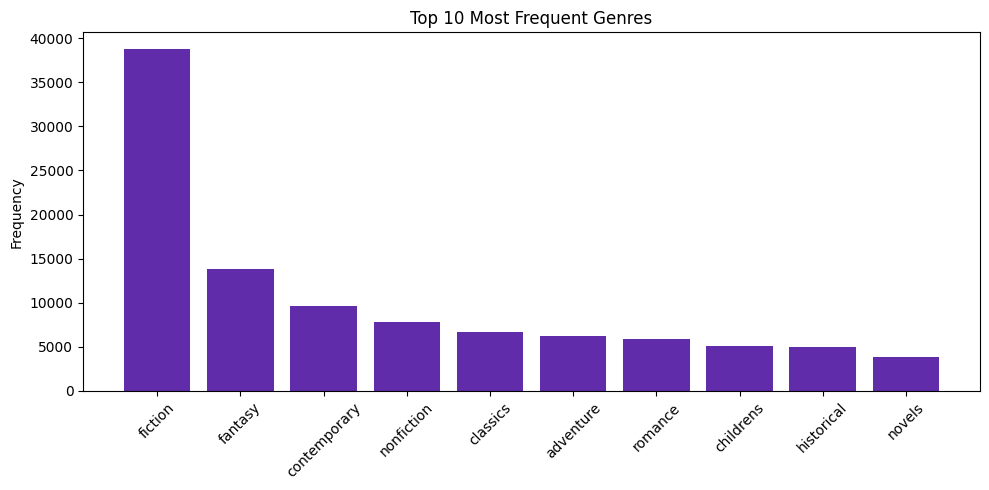

In [53]:
# Distribution of the most frequent genres
# Flatten genres list safely
all_genres = df['genres'].dropna().apply(
    lambda x: x if isinstance(x, list) else ast.literal_eval(x)
).sum()

genre_counts = Counter(all_genres)
top_genres = dict(genre_counts.most_common(10))

plt.figure(figsize=(10,5))
plt.bar(top_genres.keys(), top_genres.values(), color="#602CA9")
plt.xticks(rotation=45)
plt.title('Top 10 Most Frequent Genres')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

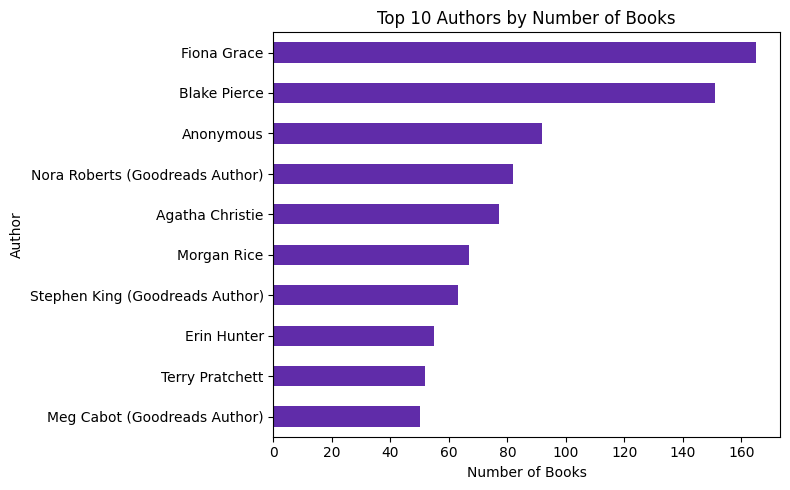

In [54]:
# Authors with the most books in the dataset
top_authors = df['author'].value_counts().head(10)

plt.figure(figsize=(8,5))
top_authors.plot(kind='barh', color='#602CA9')
plt.title('Top 10 Authors by Number of Books')
plt.xlabel('Number of Books')
plt.ylabel('Author')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

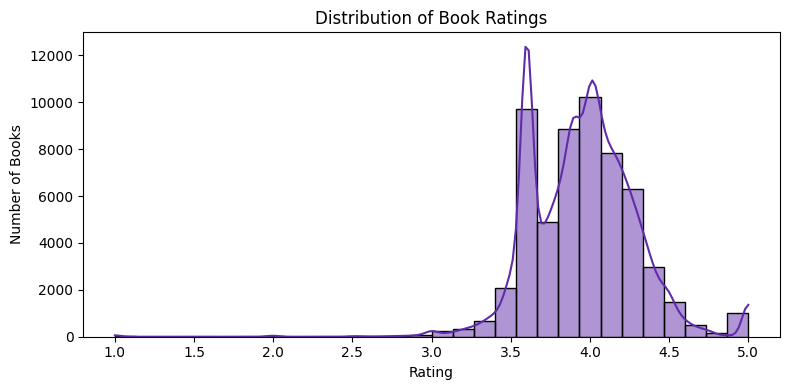

In [55]:
# Distribution of book ratings
plt.figure(figsize=(8,4))
sns.histplot(df['rating'], kde=True, bins=30, color='#602CA9')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Books')
plt.tight_layout()
plt.show()

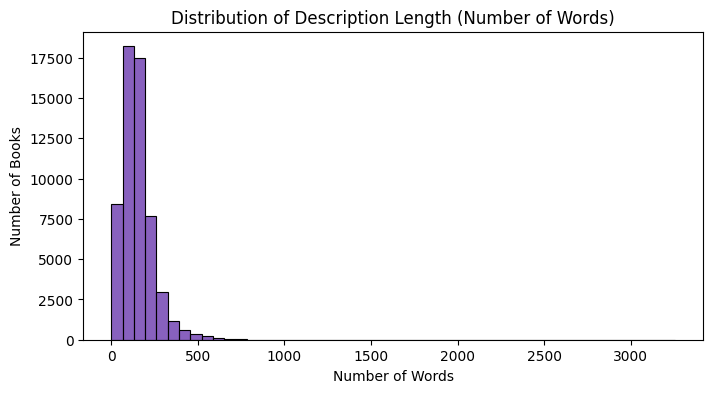

In [56]:
# Description length
df['desc_length'] = df['description'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

plt.figure(figsize=(8,4))
sns.histplot(df['desc_length'], bins=50, color='#602CA9')
plt.title('Distribution of Description Length (Number of Words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Books')
plt.show()

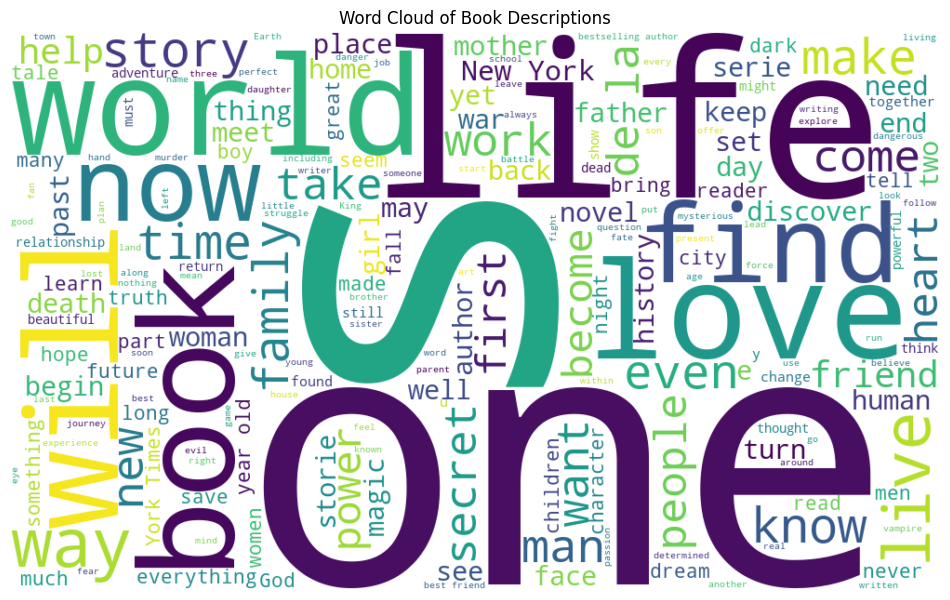

In [57]:
# Word Cloud
text = " ".join(df['description'].dropna().tolist())
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Book Descriptions')
plt.show()

In [58]:
# Save intermediate dataset
df.to_csv('../data/final/final_raw_data.csv', index=False)

In [59]:
# Load the new Dataset
df_final = pd.read_csv('../data/final/final_raw_data.csv')
df_final

,title,series,author,rating,description,language,genres,bookFormat,pages,publisher,publishDate,firstPublishDate,awards,coverImg,series_number,desc_length
0,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,en,"['adventure', 'dystopia', 'fantasy']",Hardcover,374,Scholastic Press,2008-09-14 00:00:00,False,True,https://i.gr-assets.com/images/S/compressed.ph...,1.0,147
1,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,en,"['adventure', 'childrens', 'classics']",Paperback,870,Scholastic Inc.,2004-09-28 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,5.0,136
2,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,en,"['classics', 'fiction', 'historical']",Paperback,324,Harper Perennial Modern Classics,2006-05-23 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,NaN,137
3,Pride and Prejudice,Standalone Novel,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,en,"['classics', 'fiction', 'historical']",Paperback,279,Modern Library,2000-10-10 00:00:00,True,False,https://i.gr-assets.com/images/S/compressed.ph...,NaN,100
4,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,en,"['fantasy', 'fiction', 'paranormal']",Paperback,501,"Little, Brown and Company",2006-09-06 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,1.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57388,Beasts & Behemoths (Dungeons & Dragons),Standalone Novel,"Jim Zub, Stacy King, Andrew Wheeler, Official ...",3.60,Study this guide and keep it close at hand--th...,en,['fiction'],Paperback,114,Ten Speed Press,2020-10-20 00:00:00,True,False,http://books.google.com/books/content?id=1toui...,NaN,170
57389,Faculty of Dragon Riders,Standalone Novel,Dmitry Nazarov,3.60,I tamed the Black Dragon!So I thought until I ...,en,['fiction'],Paperback,401,Litres,2022-08-24 00:00:00,True,False,http://books.google.com/books/content?id=QSGFE...,NaN,52
57390,Midnight Delivery Sex,Standalone Novel,Neneko Narazaki,4.00,Mit SNS-Card zum Sammeln in der ersten Auflage...,de,['comics'],Paperback,29,Hayabusa,2021-05-04 00:00:00,True,False,http://books.google.com/books/content?id=s_8_E...,NaN,78
57391,Monster Girl: 2,Standalone Novel,Kazuki Funatsu,3.50,"Dopo il loro incontro, Yatsuki si ritrova ad a...",it,"['comics', 'isekai']",Paperback,216,Edizioni BD,2020-05-01 00:00:00,True,False,http://books.google.com/books/content?id=_yjnE...,NaN,48


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57393 entries, 0 to 74788
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             57393 non-null  object 
 1   series            57393 non-null  object 
 2   author            57393 non-null  object 
 3   rating            57393 non-null  float64
 4   description       57393 non-null  object 
 5   language          57393 non-null  object 
 6   genres            57393 non-null  object 
 7   bookFormat        57393 non-null  object 
 8   pages             57393 non-null  int64  
 9   publisher         57393 non-null  object 
 10  publishDate       57393 non-null  object 
 11  firstPublishDate  57393 non-null  bool   
 12  awards            57393 non-null  bool   
 13  coverImg          57393 non-null  object 
 14  series_number     20017 non-null  float64
 15  desc_length       57393 non-null  int64  
dtypes: bool(2), float64(2), int64(2), object(10)


In [61]:
df['genres'].apply(type).value_counts()

genres
<class 'list'>    57393
Name: count, dtype: int64

In [62]:
# Transform the strings into list (safe version to avoid wiping existing lists)
def safe_to_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            return val if isinstance(val, list) else [val]
        except:
            return [x]
    return []

df['genres'] = df['genres'].apply(safe_to_list)

- Apply Label Encoding to the columns `series`, `language`, and `bookFormat`.
- Convert boolean columns `firstPublishDate` and `awards` to integers.
- Transform the `genres` column using a `MultiLabelBinarizer`.
- Compute the average rating for each `author` and assign it accordingly.

In [63]:
# Create a copy of the dataframe for modeling
df_model = df.copy()

# Encode categorical variables using LabelEncoder
cat_cols = ['series', 'language', 'bookFormat']
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = df_model[col].fillna('missing').astype(str)
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le  # Store the encoder

# Convert boolean columns to integers
df_model['firstPublishDate'] = df_model['firstPublishDate'].astype(int)
df_model['awards'] = df_model['awards'].astype(int)

# Compute the average rating per author and use it as a new feature
author_avg = df_model.groupby('author')['rating'].mean()
df_model['author_rating'] = df_model['author'].map(author_avg)
df_model['author_rating'] = df_model['author_rating'].fillna(df_model['rating'].mean())

# Binarize genres (multi-label one-hot encoding)
mlb = MultiLabelBinarizer()
genres_ohe = mlb.fit_transform(df_model['genres'])
df_genres = pd.DataFrame(genres_ohe, columns=mlb.classes_, index=df_model.index)

# Combine with the modeling dataframe
df_model = pd.concat([df_model, df_genres], axis=1)

# Example: if you imputed ratings in df_model, copy them back to df
df['rating'] = df['rating'].fillna(df_model['rating'])


In [64]:
df_model

,title,series,author,rating,description,language,genres,bookFormat,pages,publisher,...,isekai,lgbt,magic,nonfiction,novels,paranormal,romance,suspense,thriller,young adult
0,The Hunger Games,16084,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,14,"[adventure, dystopia, fantasy]",35,374,Scholastic Press,...,0,0,0,0,0,0,0,0,0,0
1,Harry Potter and the Order of the Phoenix,6493,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,14,"[adventure, childrens, classics]",62,870,Scholastic Inc.,...,0,0,0,0,0,0,0,0,0,0
2,To Kill a Mockingbird,18387,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,14,"[classics, fiction, historical]",62,324,Harper Perennial Modern Classics,...,0,0,0,0,0,0,0,0,0,0
3,Pride and Prejudice,13752,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,14,"[classics, fiction, historical]",62,279,Modern Library,...,0,0,0,0,0,0,0,0,0,0
4,Twilight,17777,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,14,"[fantasy, fiction, paranormal]",62,501,"Little, Brown and Company",...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74779,Beasts & Behemoths (Dungeons & Dragons),13752,"Jim Zub, Stacy King, Andrew Wheeler, Official ...",3.60,Study this guide and keep it close at hand--th...,14,[fiction],62,114,Ten Speed Press,...,0,0,0,0,0,0,0,0,0,0
74780,Faculty of Dragon Riders,13752,Dmitry Nazarov,3.60,I tamed the Black Dragon!So I thought until I ...,14,[fiction],62,401,Litres,...,0,0,0,0,0,0,0,0,0,0
74786,Midnight Delivery Sex,13752,Neneko Narazaki,4.00,Mit SNS-Card zum Sammeln in der ersten Auflage...,11,[comics],62,29,Hayabusa,...,0,0,0,0,0,0,0,0,0,0
74787,Monster Girl: 2,13752,Kazuki Funatsu,3.50,"Dopo il loro incontro, Yatsuki si ritrova ad a...",30,"[comics, isekai]",62,216,Edizioni BD,...,1,0,0,0,0,0,0,0,0,0


In [65]:
# Save the final dataset
df.to_csv('../data/final/final_data.csv', index=False)

In [66]:
df_final = pd.read_csv('../data/final/final_data.csv')
df_final

,title,series,author,rating,description,language,genres,bookFormat,pages,publisher,publishDate,firstPublishDate,awards,coverImg,series_number,desc_length
0,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,en,"['adventure', 'dystopia', 'fantasy']",Hardcover,374,Scholastic Press,2008-09-14 00:00:00,False,True,https://i.gr-assets.com/images/S/compressed.ph...,1.0,147
1,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,en,"['adventure', 'childrens', 'classics']",Paperback,870,Scholastic Inc.,2004-09-28 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,5.0,136
2,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,en,"['classics', 'fiction', 'historical']",Paperback,324,Harper Perennial Modern Classics,2006-05-23 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,NaN,137
3,Pride and Prejudice,Standalone Novel,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,en,"['classics', 'fiction', 'historical']",Paperback,279,Modern Library,2000-10-10 00:00:00,True,False,https://i.gr-assets.com/images/S/compressed.ph...,NaN,100
4,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,en,"['fantasy', 'fiction', 'paranormal']",Paperback,501,"Little, Brown and Company",2006-09-06 00:00:00,True,True,https://i.gr-assets.com/images/S/compressed.ph...,1.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57388,Beasts & Behemoths (Dungeons & Dragons),Standalone Novel,"Jim Zub, Stacy King, Andrew Wheeler, Official ...",3.60,Study this guide and keep it close at hand--th...,en,['fiction'],Paperback,114,Ten Speed Press,2020-10-20 00:00:00,True,False,http://books.google.com/books/content?id=1toui...,NaN,170
57389,Faculty of Dragon Riders,Standalone Novel,Dmitry Nazarov,3.60,I tamed the Black Dragon!So I thought until I ...,en,['fiction'],Paperback,401,Litres,2022-08-24 00:00:00,True,False,http://books.google.com/books/content?id=QSGFE...,NaN,52
57390,Midnight Delivery Sex,Standalone Novel,Neneko Narazaki,4.00,Mit SNS-Card zum Sammeln in der ersten Auflage...,de,['comics'],Paperback,29,Hayabusa,2021-05-04 00:00:00,True,False,http://books.google.com/books/content?id=s_8_E...,NaN,78
57391,Monster Girl: 2,Standalone Novel,Kazuki Funatsu,3.50,"Dopo il loro incontro, Yatsuki si ritrova ad a...",it,"['comics', 'isekai']",Paperback,216,Edizioni BD,2020-05-01 00:00:00,True,False,http://books.google.com/books/content?id=_yjnE...,NaN,48


With the dataset cleaned and prepared for modeling, the first step is to standardize the language. All textual data will be translated into English for consistency and ease of analysis. Names of Chinese, Japanese and Korean authors will be preserved in their original language but converted to Pinyin or Romaji for uniform representation.